# Bait n' Switch

### Clickbait classification and removal

### Business problem

I have assumed the role of a data scientist working at a software company that wants to make improvements on their webbrowser deliverable. Market analysis has revealed that users are frustrated with the rise in clickbait and feel like the credibility of journalism has greatly diminished. The stakeholders want to offer our users the option to filter out or flag clickbait headlines from their browsing experience in order to set their browser apart from the others.


### Context

The online journalism economy is driven by pay perclick (PPC) advertising. Pay perclick is an advertisement payment structure where advertisers pay the website a fixed amount per click or view of their ad. Since total views are a 0 sum game, this put's pressure on website content generators to make the most eye catching and clickbaity title possible in a capitalistic arms race.

Click bait is defined as sensational and eye catching headlines or images that are designed to draw your attention and curiousity. Subjectively, clickbait is easy to spot. Take these two headlines as examples: 

 - "25 Useful Products Reviewers Say They Just Keep Buying Over And Over"
 - "US federal agency announces plans to begin presidential transition process following Trump election loss"
 
The first article grabs your curiousity, without actually telling you anything about the content of the article. It is vague but purports to be useful. This is known as exploiting a curiosity gap, saying something that peaks curiousity without giving enough information to satisfy it. Whereas the second article acts as summary of the entire article.
 
The danger of clickbait is that without any form of regulation or filtering, clickbait poises to replace conventional journalistic content creation in the hopes of generating more revenue. In addition, as clickbait headlines become more frequent, the signal to noise ratio of high integrity journalism and sensationlist false or misleading information will decrease until the two are difficult to parse. 

By giving user's the option to remove clickbait from their browser, we are potentially providing a feed back mechanism that forces content creators to write nonclickbait articles to be seen in the first place.

## Performance Metric
- `F1 score`: A harmonic mean of precision and recall. I am less concerned with false positives or falsenegatives than simply being wrong. Therefore, I am looking at F1 score to give an over all indication of the strength of the model
- `ROC-AUC`: This allows me to observe the raio between false positives and true positives created by the model over a range of thresholds. This will help in determining the 

## Exploratory Data Analysis and Feature Engineering

 - `Sentence Structure`: I looked into title length, average word length and stopwords
 - `Title Content`: I looked at the presence of certain types of punctuation as well as the inclusion of number
 - `Title Sentiment`: News headlines should typically be neutral
 - `Vocabulary/BOW`: I took a bag of words approach and analysed tf-idf of specific words in corpus
 
## Model Selection
 - `Naive Bayes`: By far the fastest classification algorithm and considering I want build a browser extension, speed is very important factor
 - `Logistic Regression`: Allows me to modify the threshold manually in order to tweek my precision and recall however it is a slightly slower model to run
 - `Random Forest`: Powerful ensemble method for classfication but is relatively slow compared to other methods
 - `XGboost`: The most powerful non-neural net method for classfication but is slow
 - `Support Vector Machine`: Depending on the number of articles on the screen, the support vectors dimensionality reduction may speed up the classification and past work has indicated that it is highly effective in classifying clickbait however, it is very slow.

In [1]:
# import modules

# Utility
import pandas as pd
import numpy as np
import os
import sys
from warnings import filterwarnings
import string

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# NLP
import nltk
from textblob import TextBlob
import re

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('words')

# Feature extration 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

# Statistics
from scipy import stats

# Modelling
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Set a random seed
np.random.seed(42)

# magic line
%matplotlib inline

# Set theme
plt.style.use('ggplot')

#ignore warnings
filterwarnings('ignore')

# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')


# Import module
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import preprocessing as pp
from modules import graph, modelling
# ================= Uncomment if stopwords throws and error ======================== # 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/tjh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tjh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tjh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/tjh/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tjh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Importing data

Datasets were generated from the raw data in the notebook `./notebooks/EDA/datasetCreation.ipynb`. The datasets were created such that there is no missing information. However, I determined in the notebook `./notebooks/EDA/exploring.ipynb` that dataset 2 contained only twitter posts which are very different to headlines, clickbait or no. I could make a seperate model for detecting twitter clickbait posts but for the current problem, I am interested only in news headlines.

In [2]:
# Import datasets
PATH1 = './src/data/dataframe1.csv'
PATH3 = './src/data/dataframe3.csv'
df1 = pd.read_csv(PATH1)
df3 = pd.read_csv(PATH3)

In [3]:
df1.head()

,text,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,0
1,"In Hollywood, the Easy-Money Generation Toughe...",0
2,1700 runners still unaccounted for in UK's Lak...,0
3,Yankees Pitchers Trade Fielding Drills for Put...,0
4,Large earthquake rattles Indonesia; Seventh in...,0


In [4]:
df3.head()

,id,post_text,title,timestamp,dataset,target
0,858462320779026433,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,3,0
1,858421020331560960,this is good,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,3,1
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,3,0
3,858323428260139008,Meet the happiest #dog in the world!,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,3,1
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,3,0


I cleaned up the columns and created a new dataset that only had the columns `text`, `dataset`, `target`. I included `dataset` so that during model evaluation, I could determine where most of the false negatives and false positives came from. 

In [5]:
PATHFINAL = './src/data/df_one_plus_three.csv'
df = pd.read_csv(PATHFINAL)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51538 entries, 0 to 51537
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    51538 non-null  object
 1   dataset  51538 non-null  int64 
 2   target   51538 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [7]:
df.shape, df[df.target == 1].shape, df[df.target == 0].shape

((51538, 3), (20760, 3), (30778, 3))

The current data set has 51438 documents, 20760 are clickbait and 30778 are not clickbait.

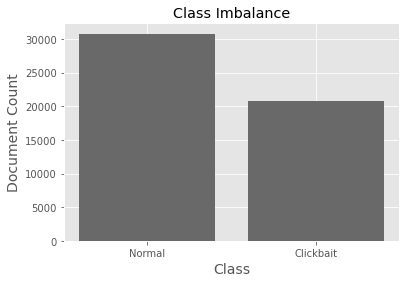

In [8]:
graph.show_class_imbalance(df, PATH = "./src/images/classimbance.png")

Class imbalance can cause the classifier to tend to predict the dominant class. In my case, this would lead to a loss of sensitivity of my model as it would predict too many headlines as being normal. 

It should be noted that `dataset1` has no class imbalance and whereas `dataset3` is imbalanced almost 3:1. In order to correct for the class imbalance, I will try upsampling, smote, class_weight='balanced' and leaving it as it is.

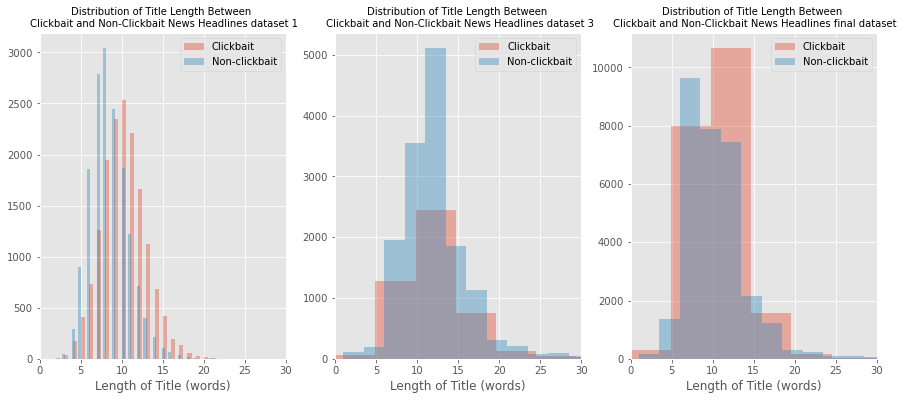

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
graph.title_lengths(df1, ax[0], content='text', x_lim=[0, 30], title='dataset 1')
graph.title_lengths(df3, ax[1], content='title', x_lim=[0, 30], title='dataset 3')
graph.title_lengths(df, ax[2], content='title', x_lim=[0, 30], title='final dataset');

Initially I suspected that there would be a large difference in the length of the words however, click bait titles show more variation in the length of the words than non click bait titles over all

In [10]:
click_lengths = (df[df.target == 1].title.apply(graph.get_len))
non_lengths = (df[df.target == 0].title.apply(graph.get_len))

click_std = np.std(click_lengths)
non_std = np.std(non_lengths)


equal_var = stats.levene(click_lengths, non_lengths)

print(f"The lengths of titles had a difference in variation of {click_std - non_std} which was significant when run through a levene's test {equal_var}")

The lengths of titles had a difference in variation of 1.1267066978191744 which was significant when run through a levene's test LeveneResult(statistic=78.71124410150307, pvalue=7.413243944769525e-19)


In [11]:
significance = stats.ttest_ind(click_lengths, non_lengths, equal_var=False)
mean_dif = int(round((click_lengths.mean()-non_lengths.mean()), 0))
print(f"Clickbait titles are on Average {mean_dif} words longer than non clickbait titles with a p value of {significance[1]}")

Clickbait titles are on Average 0 words longer than non clickbait titles with a p value of 1.4221122846913945e-20


So, though the average size of the titles did not differ, the distributions where significantly different which is supported by the results of the levenes test for equal variance.

Next, I wanted to look at at the average length of the words in the title. One would assume that clickbait titles use a shorter, snappier vocabulary however, I wanted to visualize those differences. 

Non clickbait words are on average 0.63 words longer than clickbait titles with a p value of 0.0


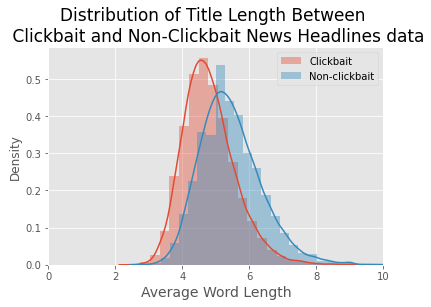

In [12]:
clickbait_words = df[df.target==1].title.apply(graph.get_average_word_length)
nonclickbait_words = df[df.target==0].title.apply(graph.get_average_word_length)
mean_difference = np.mean(nonclickbait_words) - np.mean(clickbait_words) 
p = round(stats.ttest_ind(clickbait_words, nonclickbait_words)[1], 2)
print(f"Non clickbait words are on average {round(mean_difference, 2)} words longer than clickbait titles with a p value of {p}")
graph.word_lengths(df);

As I suspected, non-click bait articles on average use slightly longer words than that of clickbait articles. Next I was interested in the content of the words.

First, I wanted to look at the `proportion of stopwords` used in each of the of the classes. This was calculated by dividing the length each title without stopwords by the same title with stopwords. To avoid a 0 division error I added 1 to the numerator and denominator. Therefore 1 is the lowest proportion possible.

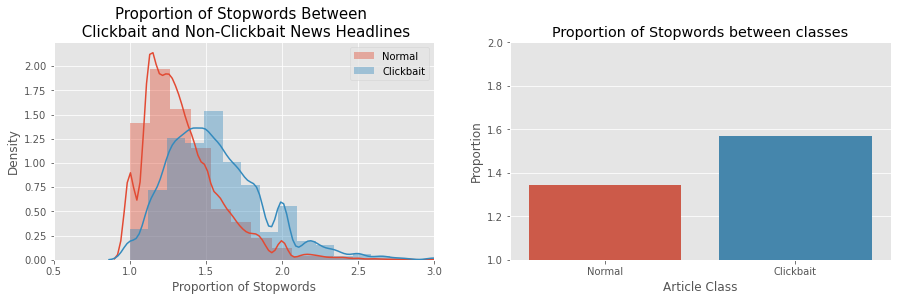

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
graph.stopword_hist(df, pp.stop_words, ax[0])
graph.stopword_bar(df, pp.stop_words, ax[1])
plt.savefig("./src/images/stopwords.png", bbox_inches="tight");

As I expected, the proporiton of stopwords in the click bait headlines was higher than in Normal headlines. Though clickbait isn't strictly speaking a lie, research into lying does support this finding. Truthful statements tend to have less filler words than dishonest ones. Here we see an example of that in the reduced number of stop words in the non clickbait articles.

In addition to stopwords, I think we are all familiar with the prevelance of cardinal numbers in clickbait articles "17 reasons you have to visit jamaica" or "top 19 best hiphop songs from the 90s". Why precisely specific numbers elicit such strong curiousity is unknown but I could speculate that it provides a tangible target to disprove.

Let's examine the proportion of articles that contain cardinal numbers to those that do not.

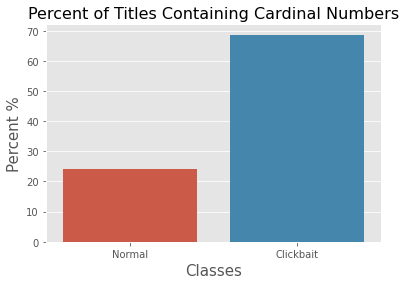

In [14]:
graph.proportion_with_cardinals(df);

70% of all clickbait titles contain cardinal numbers whereas only 20% of non-clickbait titles contain them. This is a large class divide that we can use in the model. I wonder, if the types of numbers are important. For instance, Normal news headlines will often have numbers less than 10 and also 4 digit dates. (TO DO) whereas I would expect click bait articles to be exclusively 1-100. I wouldn't expect to see any years in there at all.


Next, I will look at the actualy vocabulary of each class, to do this, I will first remove stopwords and then create and visualize frequency dictionaries.

# Use of Punctuation:

I will create a vector called frequency of punctuation and visaulize the distriution between classes

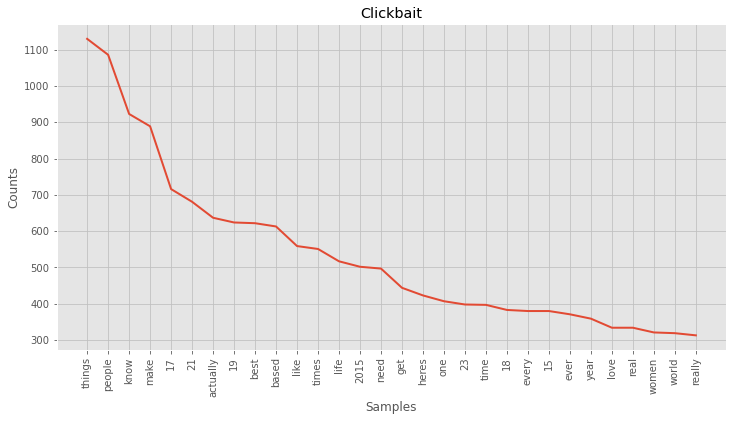

Current Vocab size is = 16399


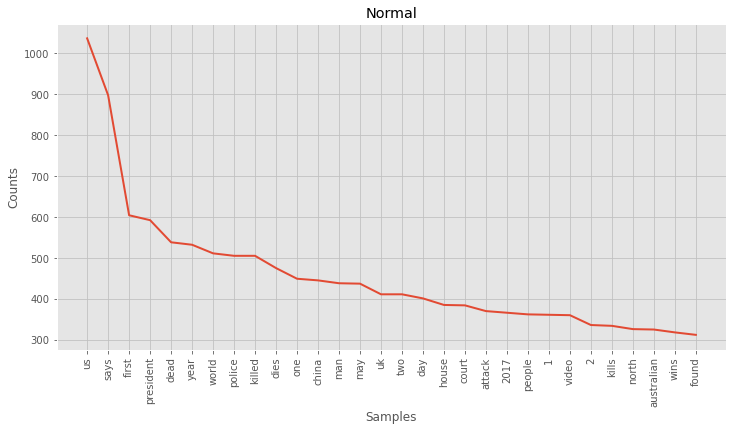

Current Vocab size is = 26476


In [15]:
# Remove stopwards
df['no_stops'] = df.title.apply(pp.remove_stopwords)

# Create frequency dictionaries
click_dict = graph.get_vocab_length(df[df.target == 1].no_stops, title="Clickbait")
normal_dict = graph.get_vocab_length(df[df.target == 0].no_stops, title="Normal")

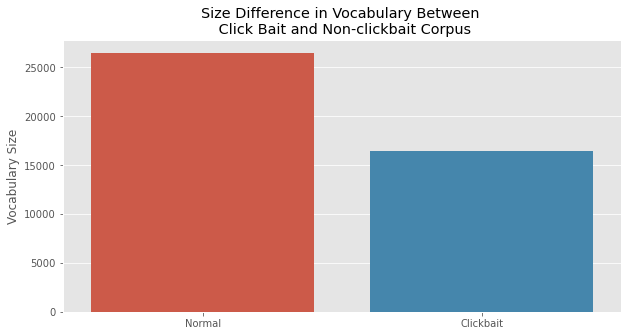

In [16]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=["Normal","Clickbait"], y=[ len(normal_dict),len(click_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus")
plt.savefig('./src/images/vocabulary.png', bbox_inches="tight");

Normal headlines use a wide variety of words whereas clickbait titles use a restricted set of words. This is likely due to the limited number of subjects that clickbait covers. Usually, consumerism, pop culture and entertainment whereas Normal headlines can cover almost anything. This means that there will be a lot of unique words that only ever occur in Normal hedlines. This is strong evidence to use something like Naive Bayes are A random forest classifier. 

Let's look closer at the kinds of words that are used in each class by creating word clouds. Word clouds visualize the frequency of words by their relative size.


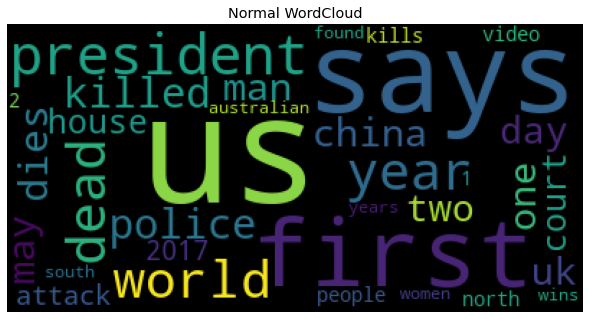

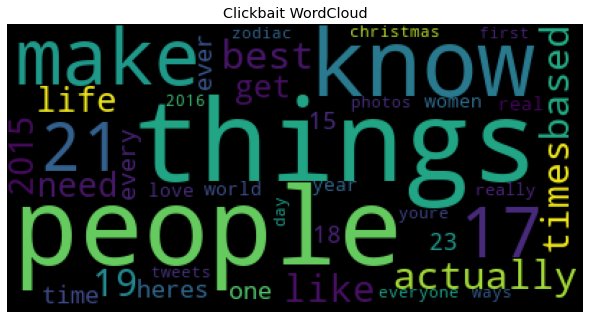

In [17]:
graph.generate_wordcloud(normal_dict, title = "Normal WordCloud", PATH = "./src/images/NORMALwc.png")

graph.generate_wordcloud(click_dict, title = "Clickbait WordCloud", PATH = "./src/images/CLICKwc.png")

What stood out to me immediately was the generic use of language in clickbait as appposed to the specificity of language in Normal headlines. But let's be more specific about that. I am interested in visualizing the differences between group in vocabularly used. That is, the most frequently used words or tokens that are in click bait headlines but are not normal headlines.


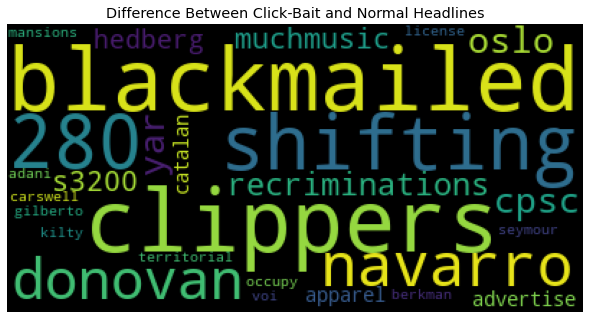

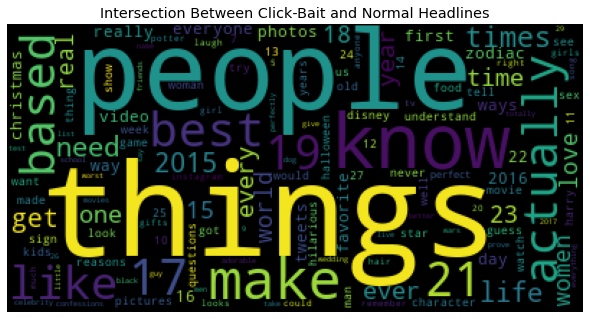

In [19]:
# Visualize the differences and the intersect between normal and clickbait headlines
graph.visualize_intersection(df)

The top image shows the words that are in normal headlines but not found in clickbait. The tone of the words is somber. The bottom image is the intersection between the the vocabularies between classes. Non specific wording, numbers and superlatives. 

# Bar plots to show the relative proporion of part of speech tags

In [20]:
def get_tags(corpus):
    return [TextBlob(word).tags for word in corpus.split()]

In [21]:
# Extract the corpus of words from each class
norm_corpus = " ".join(df[df.target == 0].no_stops.to_list())
click_corpus = " ".join(df[df.target == 1].no_stops.to_list())

In [22]:
# Tag the corpus with part of speech tagging using Textblob
norm_tag = get_tags(norm_corpus)
click_tag = get_tags(click_corpus)

In [23]:
# Extract out just the parts of speech from the text blob
norm_tag_list = []
for i, item in enumerate(norm_tag):
    try:
        norm_tag_list.append(item[0][1])
    except:
        continue
        
click_tag_list = []
for i, item in enumerate(click_tag):
    try:
        click_tag_list.append(item[0][1])
    except:
        continue

In [24]:
# Generate pos dictionaries
norm_tag_dict = graph.freq_of_specific_words(norm_tag_list, set(norm_tag_list))
click_tag_dict = graph.freq_of_specific_words(click_tag_list, set(click_tag_list))

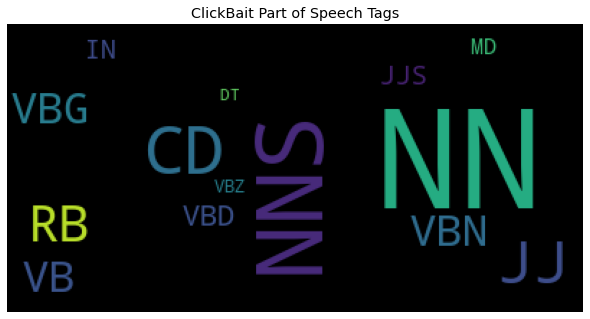

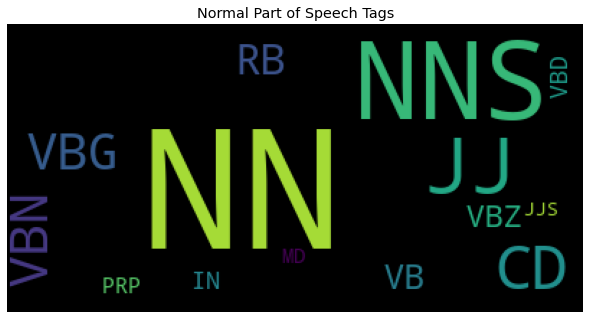

In [25]:
# Generate word clouds
graph.generate_wordcloud(click_tag_dict, title="ClickBait Part of Speech Tags")

graph.generate_wordcloud(norm_tag_dict, title="Normal Part of Speech Tags")

A word cloud here is not very revealing, I think bar plots would be better suited for showing the distribution of part of speech tags. Both classes are dominated by Nouns.

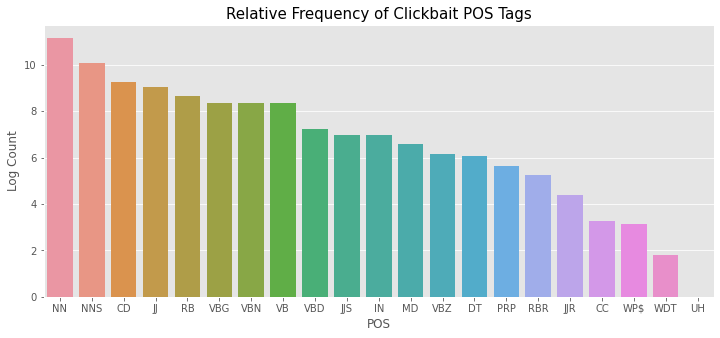

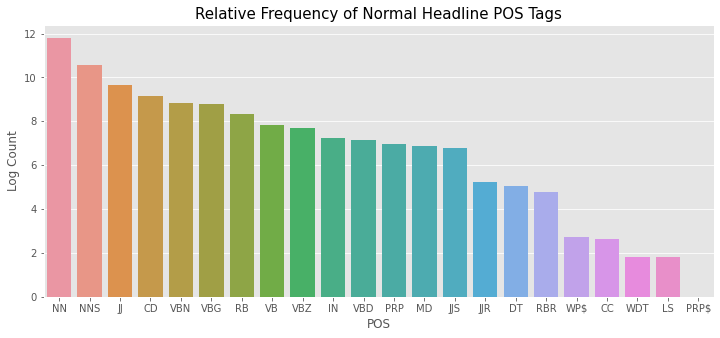

In [38]:
# Generate sorted dictionaries 
click_pos_df = pd.DataFrame(click_tag_dict.items(), columns = ['POS', "Count"]).sort_values('Count', ascending=False)
norm_pos_df = pd.DataFrame(norm_tag_dict.items(), columns = ['POS', "Count"]).sort_values('Count', ascending=False)

click_pos_df['Log Count'] = np.log(click_pos_df.Count)
norm_pos_df['Log Count'] = np.log(norm_pos_df.Count)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
sns.barplot(data=click_pos_df, x='POS', y = 'Log Count', ax=ax)
plt.title("Relative Frequency of Clickbait POS Tags", Size=15)
plt.savefig("./src/images/clickPOS.png", bbox_inches='tight' )

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (12,5))
sns.barplot(data=norm_pos_df, x='POS', y = 'Log Count', ax=ax)
plt.title("Relative Frequency of Normal Headline POS Tags", Size=15);

# Key Differences in POS

### Realtively more important tags for clickbait
- JJS: The Superlative eg Biggest! Best! Funnest!
- PRP: Personal Pronouns eg I, he, she
- RB: Adverb eg Very, Silently, Colorfully. 
- VBG: verb, gerund/present participle taking. eg **Playing** gameboy is fun!
 
I was surprised to learn that the relative structure of the two classes was similar in the aggregate. When we see click bait, it is almost immediately apparent whether it is being sensationalist and eye catching, however, from the parts of speech used, they are on average quite similar. This highlights the difficulty of the problem


The parts of speech tags are not entirely different to each other. That is, there is no unique part of speech to click bait that would set it apart. However, I will include them in the model as the it is difficult to tell what a model may or may not be able to pick up 

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [28]:
def get_polarity(title):
    return analyzer.polarity_scores(title.lower())['compound']

In [29]:
click_polarity = df[df.target==1].title.apply(get_polarity)
normal_polarity = df[df.target==0].title.apply(get_polarity)

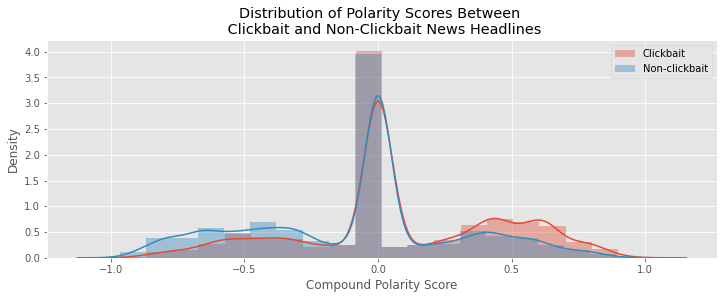

In [32]:
fig, ax = plt.subplots(figsize = (12,4))
for a, b in zip([click_polarity, normal_polarity], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=20, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlabel("Compound Polarity Score")
ax.set_title("Distribution of Polarity Scores Between \n Clickbait and Non-Clickbait News Headlines")
plt.savefig("./src/images/sentiment.png", bbox_inches="tight");

The vast majority of headlines fall with the central or neutral range. However, the number of clickbait headlines that are net positive or greater than 0.5 is greater. This came as a surprise as I would have thought that clickbait would be more extreme in both directions, however, that was not the case.


# Baseline modelling

- Naive Bayes
- Logistic Regression

I will use tf-idf after a train test split in conjunction with a decision tree, logistic regressor and a bayes classifier to find suitable baseline model.

Without any hyperparamater tuning, The baseline models perform quite poorly on f1 scores. However they do a good job relative to the dummy classifier. The best without any hyperparamater tuning was Logistic Regression. The advantage to Logistic Regression is that it will allow me to manually adjust the decision threshold.

In [30]:
# Baseline on only the Chakbroty data
bayes1, log1 = modelling.run_baselines(df[df.dataset==1])

Models: 		 Dummy		 Naive Bayes		Logistic Regression
Training f1 scores:(0.49992147008010046, 0.9930541929914061, 0.9816418977986172) 

 Testing f1 Scores: (0.5007795447458685, 0.9626168224299066, 0.9480798771121351)


Working with the first dataset, it seems as thoughI can get really strong results right off of the mark.

In [31]:
# Baseline on only the Webis 2017 data
bayes3, log3 = modelling.run_baselines(df[df.dataset==3])

Models: 		 Dummy		 Naive Bayes		Logistic Regression
Training f1 scores:(0.24302736676705514, 0.3449913644214162, 0.3341268123782731) 

 Testing f1 Scores: (0.24946236559139787, 0.027455121436114043, 0.29012875536480687)


However, dataset 3 (Webis 2017) produces terrible results in isolation. These results are terrible. Probably due to the fact that the data collection method were flawed. They asked the participants to select out of 5 how clickbaity the headline was. From my analysis this seemed to have fundamentally changed how people think about click bait due to the gross differences between the baseline models.

In [32]:
bayes, log = modelling.run_baselines(df)

Models: 		 Dummy		 Naive Bayes		Logistic Regression
Training f1 scores:(0.4012556216232531, 0.9462345621691894, 0.8923475165830771) 

 Testing f1 Scores: (0.412289156626506, 0.8300662079709203, 0.8339711146772004)


### One portion of my data is pulling the rest of the numbers down. 

However, the first thing to notice here is massive difference in predictability between datasets. Notice that the first data set from Chakraborty et al., 2016 has really high numbers (f1 = 0. 96) whereas Webis 2017 was unbelievably poor. Below, I will run just a peace of mind, secondary calculation to insure that the nothing went wrong with the above implementation.

I find it interesting that the results are as high as they given how badly one data set performs on the baseline. I think that the model learned from the high quality data and was able to transfer that learning to poorly labelled items

In [64]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
X = df.title
y = df.target
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(X, y, 
                                            test_size = 0.2,
                                                    random_state=42)
#tfidf
tfidf.fit(X_train_bayes)
X_train_tfidf = tfidf.transform(X_train_bayes)
X_test_tfidf = tfidf.transform(X_test_bayes)

# Bayes
bayes_clf = BernoulliNB(alpha=0.3, fit_prior=True)

bayes_clf.fit(X_train_tfidf, y_train_bayes)
y_hat_bayes=bayes_clf.predict(X_test_tfidf)
y_hat_train_bayes = bayes_clf.predict(X_train_tfidf)
f1_score(y_test_bayes, y_hat_bayes)

0.8596086058101374

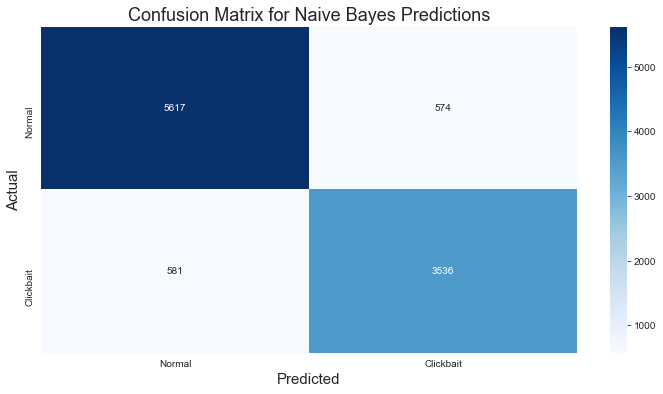

AUC: 0.9436098582618951


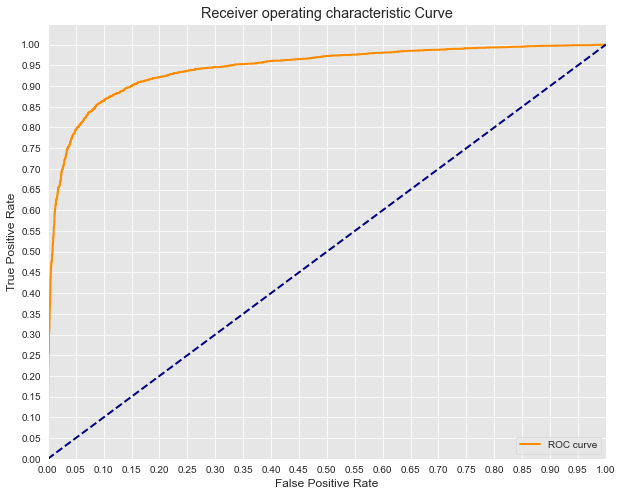

In [65]:
graph.plot_cmatrix(y_test_bayes, y_hat_bayes,model = 'Naive Bayes')
graph.plot_roc_curve(y_test_bayes, bayes_clf.predict_proba(X_test_tfidf)[:,1])

It's still not good enough to put a model into production with but it is almost twice as good as a dummy prediction which is promising. 

### Include the features that I discovered during EDA
- title length, words and characters
- ratio of stopwords
- presence of a number 
- total punctuation used

I will first run the data through a model and after that I will take the predictions, concatenate them with my engineered features and run that through the model again in the hopes that some of them will be over turned.

### Engineer features based on EDA

In [66]:
features = modelling.generate_features(df)
feature_df = pd.DataFrame(features).T
feature_df.columns = ['average_len','length', 'stop_proportion', 'punct_prop', 'exclamation_', 'get_polarity_']

## Concatenate the features onto the predictions and run it through a logistic regression.

The idea here is to use the output of the Bernoulli Naive Bayes as a Feature alongwith the engineered features to try and acheive an increase in f1 score. The Logic is to run the train data through the Bernoulli, then generate the features, concatenate the features onto the predictions, fit a logistic regression onto that and then predict on the test data using the same method.

In [67]:
# Generate features of the X_train
feature_df = pd.DataFrame(modelling.generate_features(X_train_bayes)).T
feature_df.columns = ['average_len','length', 'stop_proportion', 'punct_prop', 'exclamation_', 'get_polarity_']

# Create a combined feature df with training predictions                 
fy=pd.DataFrame(y_hat_train_bayes)
fX = pd.concat([feature_df, fy])

# Apologies for this sloppy code, but I was unable to concatenate the dataframes
Xf_train = fX.reset_index().merge(fy, left_index=True, right_index=True)
Xf_train.drop(columns = ['index', '0_x'], inplace=True)

# ==================== Repeat process for testing data =====================

y_hat_test_bayes=bayes_clf.predict(X_test_tfidf)

# Generate features of the X_test
feature_df = pd.DataFrame(modelling.generate_features(X_test_bayes)).T
feature_df.columns = ['average_len','length', 'stop_proportion', 'punct_prop', 'exclamation_', 'get_polarity_']

# Create a combined feature df with training predictions                 
fy=pd.DataFrame(y_hat_test_bayes)
fX = pd.concat([feature_df, fy])

# Merge the predictions onto the features
Xf_test = fX.reset_index().merge(fy, left_index=True, right_index=True)
Xf_test.drop(columns = ['index', '0_x'], inplace=True)  

In [68]:
log_clf = LogisticRegression(class_weight='balanced')

log_clf.fit(Xf_train, y_train_bayes)

y_hat_log__train = log_clf.predict(Xf_train)
y_hat_test_eng = log_clf.predict(Xf_test)
f1_score(y_train_bayes, y_hat_train_bayes), f1_score(y_test_bayes, y_hat_test_eng)

(0.972651818236102, 0.8594699732555312)

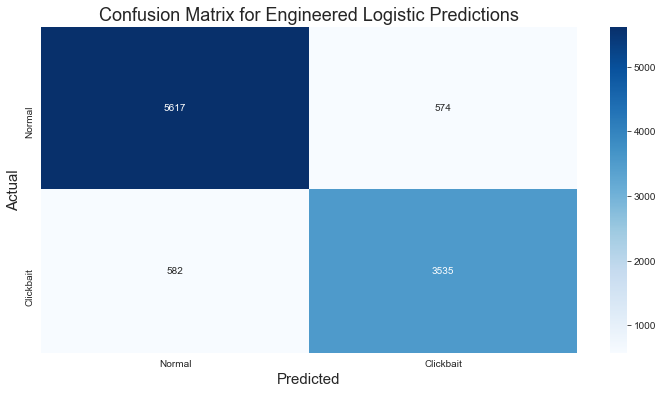

AUC: 0.8775798407013212


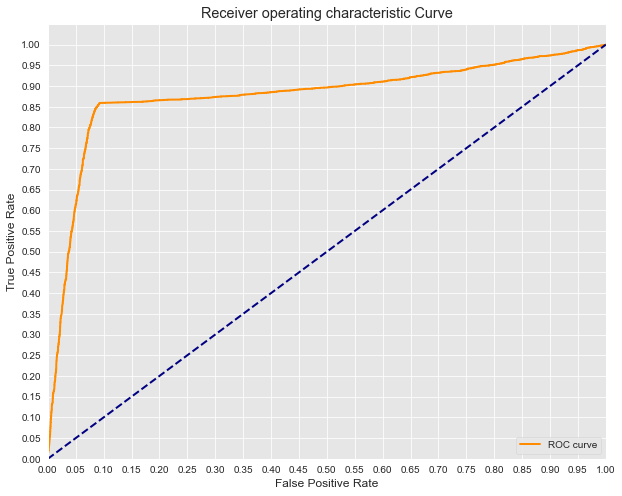

In [69]:
graph.plot_cmatrix(y_test_bayes, y_hat_test_eng, model='Engineered Logistic')
graph.plot_roc_curve(y_test_bayes, log_clf.predict_proba(Xf_test)[:,1])

Ok, so all of that gave me a 0.01 increase in f1 score. I believe that I am reaching the theoretical limit of what I can acheive on this data set.

## Support Vector Machine

In [51]:
from sklearn.svm import SVC

svm_clf= SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)

In [70]:
X = df.title
y = df.target


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size = 0.2,
                                            random_state=42,
                                            stratify=df.dataset) # To insure that data sets are equally represente
# Clean the data
X_train = X_train.apply(pp.preprocess)
X_test = X_test.apply(pp.preprocess)

# Instantiate my tfidf Vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        max_features = 100000) # Reduce the feature space. 

#tfidf
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
import time
start_time = time.time()
svm_clf.fit(X_train_tfidf, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
y_hat_svm_tr = svm_clf.predict(X_train_tfidf)
f1_score(y_train, y_hat_svm_tr)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
start_time = time.time()
y_hat_svm_te = svm_clf.predict(X_test_tfidf)
f1_score(y_test, y_hat_svm_te)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
f1_score(y_train, y_hat_svm_tr), f1_score(y_test, y_hat_svm_te)

In [ ]:
graph.plot_cmatrix(y_test, y_hat_te, model = 'Linear SVM')
graph.plot_roc_curve(y_test, svm_clf.predict_proba(X_test_tfidf)[:,1])

This gave me a 1 point increase over the baseline. I will run a random forest model and see if I can improve but I think that I have reached a limit on what these models can achieve with this data. The reason for this is that the second data set that I have included in my analysis was flawed during the collection. I still think that the Bernoulli bayes and Logistic Regression are my best models so far.

## Random Forest

In [ ]:
# Start off with the default paramaters
start_time = time.time()
forest_clf = RandomForestClassifier(oob_score=True )

forest_clf.fit(X_train_tfidf, y_train)
y_hat_train_forest = forest_clf.predict(X_train_tfidf)
y_hat_test_forest = forest_clf.predict(X_test_tfidf)

print(f1_score(y_train, y_hat_train_forest), f1_score(y_test, y_hat_test_forest))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
graph.plot_cmatrix(y_test, y_hat_test_forest)
graph.plot_roc_curve(y_test, forest_clf.predict_proba(X_test_tfidf)[:,1])

The Random Forest with no hyper paramater tuning gave a f1 score of 0.81 on the testing set. I think that the model is way over fit as the training data acheived nearly perfect scores. The source of over fitting could either come from the 